In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MSMRD as mrd
import MSMRD.integrators as integrators
import MSMRD.potentials as potentials
import MSMRD.analysis as analysis
import pickle
%matplotlib inline

In [2]:
class MSMmodel(object):    
    def __init__(self, tmatrix, centers, regionMap):
        self.tmatrix = tmatrix
        self.centers = centers
        self.regionMap = regionMap

In [3]:
msmmodel = pickle.load(open("../data/msmmodel_lag500_rentry1.8-2.0_rexit2.3-2.5.p", "rb"))
print msmmodel.regionMap['rentry_int']
print msmmodel.regionMap['rexit_int']

[1.8, 2.0]
[2.3, 2.5]


In [4]:
#truncate transition matrix to omit bath state
Ttrunc = msmmodel.tmatrix[:-1,:-1]
for i in range(Ttrunc.shape[0]):
    Ttrunc[i,:] /= np.sum(Ttrunc[i,:])
print np.allclose(np.sum(Ttrunc, axis=1), 1.)

True


In [5]:
#create msm and integrator object to set up the simulation
r0 = np.array([3.0, 0.])
p = mrd.particle(r0, 1.)
exitRadius = msmmodel.regionMap['rexit_int'][0]
msm = mrd.MSM(Ttrunc, msmmodel.centers[:-1], exitR=exitRadius)
integrator = integrators.MSMRDMilestoningReflective(msm, 4.0, p, 0.05, msmmodel.regionMap)

In [6]:
sim = mrd.simulation(integrator)
sim.run(10000000, sample=True)

In [7]:
pickle.dump(sim.traj, open("/srv/data/dibakma/MSMRD/modifiedLJ2D/milestoning/reflectiveRing/hybridModel/traj_lag500_rentry1.6-2.0_rexit2.4-3.0.p", "wb"))

In [7]:
sim.traj[0]
unboundRadius = 2.3
#1 corresponds to unbound state, 0 to bound
b = np.zeros(len(sim.traj))
b[0] = 1
for i in range(1, len(sim.traj)):
    if b[i-1] == 1:
        if sim.traj[i,3] == 0:
            b[i] = 0
        else:
            b[i] = 1
    if b[i-1] == 0:
        if (np.linalg.norm(sim.traj[i,1:3]) >= unboundRadius and sim.traj[i,3] == -1):
            b[i] = 1
        else:
            b[i] = 0

In [8]:
transitions = b[1:]-b[:-1]
AtoB = np.where(transitions == 1)[0]
BtoA = np.where(transitions == -1)[0]
def transitionTimes(AtoB, BtoA):
    if len(AtoB) == len(BtoA):
        if AtoB[0] < BtoA[0]:
            print "case1"
            tauBtoA = BtoA - AtoB
            tauAtoB = AtoB[1:] - BtoA[:-1]
        else:
            print "case2"
            tauAtoB = AtoB - BtoA
            tauBtoA = BtoA[1:] - AtoB[:-1]
    elif len(AtoB)+1 == len(BtoA):
        if AtoB[0] < BtoA[0]:
            print "case3"
            tauBtoA = BtoA[:-1] - AtoB
            tauAtoB = AtoB[1:] - BtoA[:-2]
        else:
            print "case4"
            tauAtoB = AtoB - BtoA[:-1]
            tauBtoA = BtoA[1:] - AtoB
    elif len(AtoB)-1 == len(BtoA):
        if AtoB[0] < BtoA[0]:
            print "case5"
            tauBtoA = BtoA - AtoB[:-1]
            tauAtoB = AtoB[1:] - BtoA
        else:
            print "case6"
            tauAtoB = AtoB[:-1] - BtoA
            tauBtoA = BtoA[1:-1] - AtoB[:-2]
    else:
        return None
    return tauAtoB, tauBtoA
tauAtoB, tauBtoA = transitionTimes(AtoB, BtoA)

case2


In [9]:
timestep = 0.050
print "mean tauBtoA", np.mean(timestep*tauBtoA)
print "std tauBtoA", np.std(timestep*tauBtoA)
print "mean tauAtoB", np.mean(timestep*tauAtoB)
print "std tauAtoB", np.std(timestep*tauAtoB)
print "mean stationary distribution", np.mean(tauAtoB)/np.mean(tauBtoA)

mean tauBtoA 6.74166958431
std tauBtoA 7.1094935975
mean tauAtoB 1.21542801216
std tauAtoB 0.997149372147
mean stationary distribution 0.180285906474


In [11]:
np.sum(b)/float(len(b))

0.88802630000000005

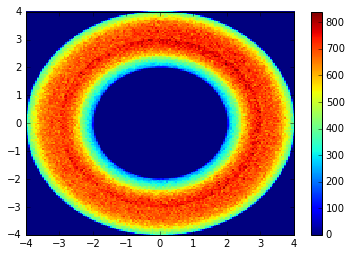

In [14]:
BDregion = np.where(sim.traj[:,3]==-1)[0]
obj = plt.hist2d(sim.traj[BDregion,1], sim.traj[BDregion,2], bins=150)
plt.colorbar()

In [13]:
print sim.traj[0]

[ 0.          2.49193422 -0.06476743 -1.        ]


In [29]:
integrator.Re

2.0